# Load and clean Dataset

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/oversampled_dataset_3labels.csv')

In [ ]:
df=df.drop('Unnamed: 0', axis=1)

In [ ]:
df

In [ ]:
import re
PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace 

In [ ]:
def clean_text(text):
    text = text.lower() 
    # replace the matched string with ' '
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

In [ ]:
def clean_sentences(df):
    print('Cleaning sentences...')
    df['desired_answer'] = df['desired_answer'].apply(clean_text)
    df['student_answer'] = df['student_answer'].apply(clean_text)
    return df

In [ ]:
df = clean_sentences(df)

Cleaning sentences...


In [ ]:
df

# Install Hugging and datasets libraries

In [ ]:
!pip install --upgrade transformers datasets accelerate

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
dataset = Dataset.from_pandas(df)
dataset.set_format("pt")

In [ ]:
dataset

Dataset({
    features: ['desired_answer', 'student_answer', 'label'],
    num_rows: 5259
})

# Load tokenizer and tokenize dataset

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["desired_answer"], examples["student_answer"], padding="max_length", truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
tokenized_dataset

Dataset({
    features: ['desired_answer', 'student_answer', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5259
})

Split data into train and test

In [ ]:
train_test = tokenized_dataset.train_test_split(test_size=0.3, seed=1178435)
train_test

In [ ]:
val_test = train_test['test'].train_test_split(test_size=0.5,)
val_test

See if there is any model answers that appear in both training and test datasets

In [ ]:
for a, b in zip(train_test['test']['desired_answer'],train_test['train']['desired_answer']):
  if a==b:
    print('yes')

# visualize the data

In [ ]:
df_train = pd.DataFrame( train_test['train'] )
df_test = pd.DataFrame( train_test['test'] )

In [ ]:
df_train['label']=df_train['label'].apply(lambda x:x.numpy())
df_test['label']=df_test['label'].apply(lambda x:x.numpy())

In [ ]:
pd.value_counts(df_train['label']).plot.bar()

In [ ]:
pd.value_counts(df_test['label']).plot.bar()

# Download the model and start Training

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to("cuda")

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    optim="adafactor",
    num_train_epochs=8,
    weight_decay=0.01,
    fp16=True
)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
y_preds = []
y_trues = []

In [ ]:
def compute_metrics(eval_pred):
  pred, labels=eval_pred
  pred=np.argmax(pred,axis=1)

  acc=accuracy_score(labels,pred)
  f_score=f1_score(labels, pred, average='weighted')
  cohen_score = cohen_kappa_score(labels, pred)

  y_preds.append(pred)
  y_trues.append(labels)

  return {'acc':acc, 'f_score':f_score, 'cohen_score':cohen_score}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=val_test['train'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Evaluate Model

In [ ]:
trainer.evaluate()

In [ ]:
trainer.evaluate(val_test['test'])

# Confusion Matrix

In [ ]:
from keras.utils import to_categorical
num_classes = 5
y_categorial = to_categorical(y_preds, num_classes)
y_pred = y_categorial.argmax(1)

In [ ]:
y_trues_cat = to_categorical(y_trues, num_classes)
y_true=y_trues_cat.argmax(1)

In [ ]:
y_test_non_category = [int(np.argmax(t)) for t in y_trues_cat.tolist()[0] ]
y_predict_non_category = [ int(np.argmax(t)) for t in y_categorial.tolist()[0] ]

In [ ]:
confusion = confusion_matrix(y_test_non_category,y_predict_non_category)

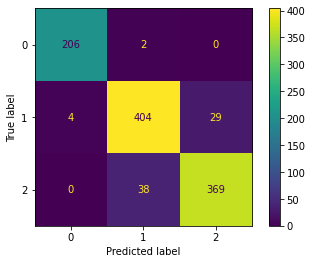

In [ ]:
import matplotlib.pyplot as plt
disp=ConfusionMatrixDisplay(confusion)
disp.plot()
plt.show()

# predict and save model

In [ ]:
model = model.to('cpu')

In [ ]:
inputs = tokenizer("A computer is a machine that can be programmed to carry out sequences of arithmetic or logical operations automatically", "I don't know", padding="max_length", truncation=True, return_tensors="pt")

In [ ]:
import torch
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_0'

In [ ]:
model.save_pretrained('/model')

Configuration saved in /content/model/config.json
Model weights saved in /content/model/pytorch_model.bin
